In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=0.8)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# **Load**

In [3]:
import warnings

# Ignore FutureWarnings from the tokenization_utils_base module
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")


In [4]:
real = pd.read_csv("/content/drive/MyDrive/NLP_course_AF/true.csv")
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
FAKE_CLASS = 1
REAL_CLASS = 0

In [6]:
real['label'] = REAL_CLASS

In [7]:
real.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [8]:
fake = pd.read_csv("/content/drive/MyDrive/NLP_course_AF/fake.csv")
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
fake['label'] = FAKE_CLASS
fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [10]:
fake = fake[:2000]
real = real[:2000]

# **Concatenate Two DataFrames**

In [11]:
# Concatenate the DataFrames along the rows (axis=0)
df = pd.concat([real, fake], ignore_index=True)
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [12]:
df=df.dropna()

In [13]:
df.shape

(4000, 5)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4000 non-null   object
 1   text     4000 non-null   object
 2   subject  4000 non-null   object
 3   date     4000 non-null   object
 4   label    4000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 156.4+ KB


In [15]:
df['label'].value_counts()

label
0    2000
1    2000
Name: count, dtype: int64

# **Model**

In [16]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [19]:
token_lens = []

for txt in df.text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512,truncation=True)
      token_lens.append(len(tokens))

In [20]:
selected_columns = ['text', 'label']
df = df[selected_columns]

In [21]:
MAX_LEN = 512

In [22]:
class FakeNewsDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [23]:
df_train, df_test = train_test_split(df, test_size=0.30, shuffle=True)
df_val, df_test = train_test_split(df_test, test_size=0.50,shuffle=True)

In [24]:
df_train.shape, df_val.shape, df_test.shape

((2800, 2), (600, 2), (600, 2))

In [25]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = FakeNewsDataset(
    text=df.text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [26]:
import warnings

# Ignore the specific FutureWarning related to truncation
warnings.filterwarnings("ignore", message="Truncation was not explicitly activated*")

In [27]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [28]:
data = next(iter(train_data_loader))
data.keys()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [29]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


In [30]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [32]:
class FakenewsClassifier(nn.Module):
  def __init__(self, n_classes):
    super(FakenewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #model
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [33]:
model = FakenewsClassifier(2)
model = model.to(device)

In [34]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [35]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5023, 0.4977],
        [0.3489, 0.6511],
        [0.2759, 0.7241],
        [0.3333, 0.6667],
        [0.4317, 0.5683],
        [0.3950, 0.6050],
        [0.2982, 0.7018],
        [0.4291, 0.5709]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# ***Training***

In [36]:
EPOCHS = 5
LOAD_WEGHITS = False

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
import warnings

# Ignore FutureWarnings from the tokenization_utils_base module
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")


In [38]:
best_model_path = "/content/drive/MyDrive/NLP_course_AF/BERTbest_model_state.bin"

In [39]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from collections import defaultdict

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    return model

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    data_loader = tqdm(data_loader, desc="Training", unit="batch")

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(
    model,
    data_loader,
    loss_fn,
    device,
    n_examples
):
    model = model.eval()

    losses = []
    correct_predictions = 0

    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

# Initialize history and best_accuracy
history = defaultdict(list)
best_accuracy = 0

if not LOAD_WEGHITS:
    # Training loop
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device,
            len(df_val)
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Save the best model
        if val_acc > best_accuracy:
            save_model(model, best_model_path)
            best_accuracy = val_acc
            print(f"Best model saved with accuracy {best_accuracy}")

    print(f"Training complete. Best accuracy: {best_accuracy}")

else:
    # Loading the best model
    model = load_model(model, best_model_path)
    model = model.to(device)

Epoch 1/5
----------


Training:   0%|          | 0/350 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 350/350 [04:38<00:00,  1.26batch/s, loss=0.0458]


Train loss 0.045783869594639065 accuracy 0.9871428571428571


Evaluating: 100%|██████████| 75/75 [00:18<00:00,  4.14batch/s, loss=6.56e-5]


Val   loss 6.559942252351903e-05 accuracy 1.0

Best model saved with accuracy 1.0
Epoch 2/5
----------


Training: 100%|██████████| 350/350 [04:39<00:00,  1.25batch/s, loss=0.00657]


Train loss 0.00657329249182242 accuracy 0.9992857142857143


Evaluating: 100%|██████████| 75/75 [00:17<00:00,  4.22batch/s, loss=0.000944]


Val   loss 0.0009441306590936923 accuracy 1.0

Epoch 3/5
----------


Training: 100%|██████████| 350/350 [04:38<00:00,  1.26batch/s, loss=0.00747]


Train loss 0.0074682310303874795 accuracy 0.9982142857142857


Evaluating: 100%|██████████| 75/75 [00:17<00:00,  4.21batch/s, loss=0.000868]


Val   loss 0.0008681807761846963 accuracy 1.0

Epoch 4/5
----------


Training: 100%|██████████| 350/350 [04:38<00:00,  1.26batch/s, loss=3.06e-5]


Train loss 3.0623342957239534e-05 accuracy 1.0


Evaluating: 100%|██████████| 75/75 [00:17<00:00,  4.22batch/s, loss=0.000747]


Val   loss 0.0007469723062483051 accuracy 1.0

Epoch 5/5
----------


Training: 100%|██████████| 350/350 [04:38<00:00,  1.26batch/s, loss=2.46e-5]


Train loss 2.4551024861076647e-05 accuracy 1.0


Evaluating: 100%|██████████| 75/75 [00:17<00:00,  4.21batch/s, loss=0.000681]

Val   loss 0.0006812417488739205 accuracy 1.0

Training complete. Best accuracy: 1.0


In [50]:
history['train_acc']

[tensor(0.9871, device='cuda:0', dtype=torch.float64),
 tensor(0.9993, device='cuda:0', dtype=torch.float64),
 tensor(0.9982, device='cuda:0', dtype=torch.float64),
 tensor(1., device='cuda:0', dtype=torch.float64),
 tensor(1., device='cuda:0', dtype=torch.float64)]

In [53]:
def tensors_to_list(tensor_list):
    return [t.cpu().item() for t in tensor_list]

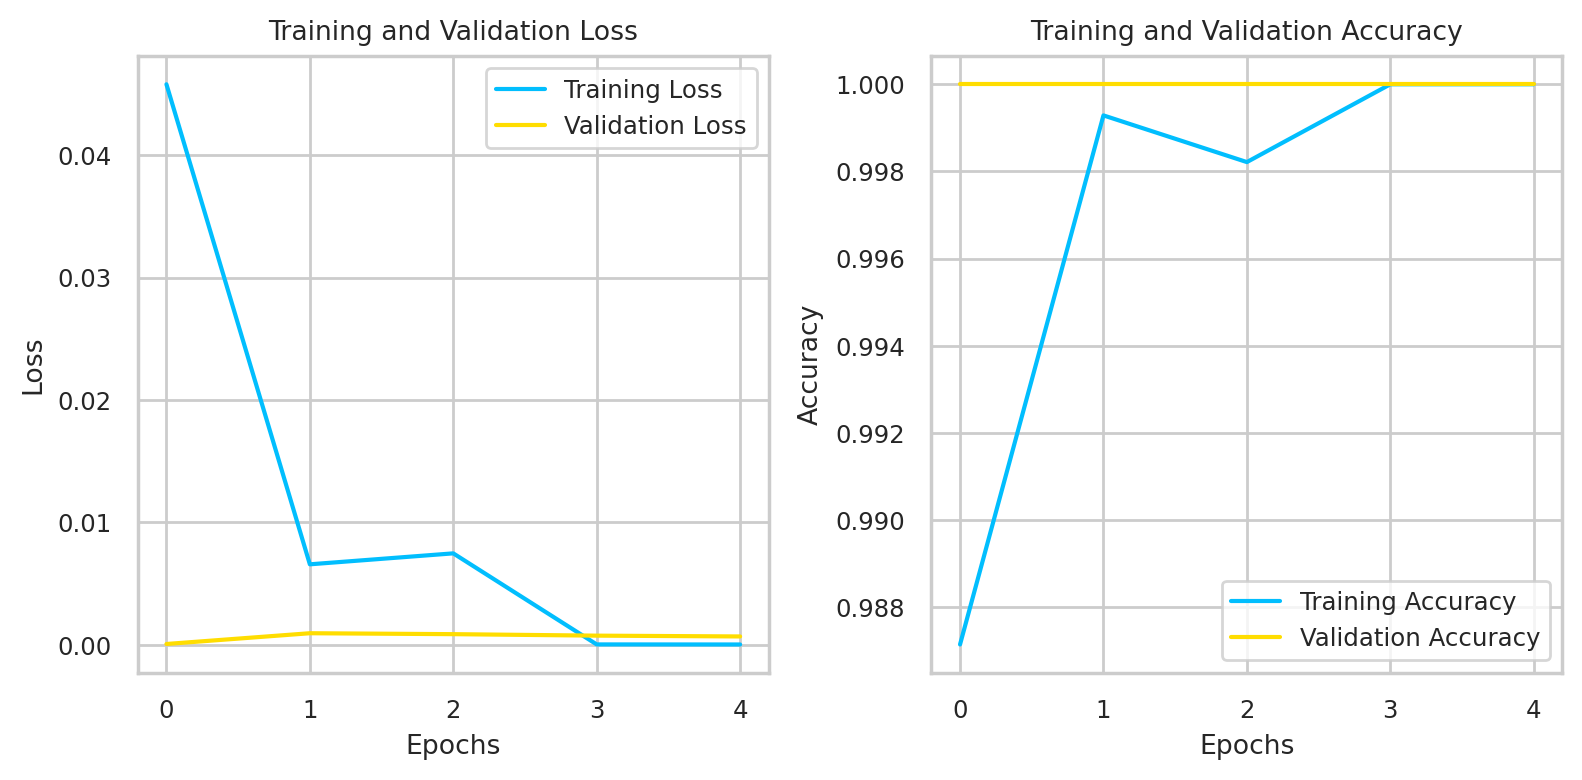

In [58]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tensors_to_list(history['train_acc']), label='Training Accuracy')
plt.plot(tensors_to_list(history['val_acc']), label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **Evaluation**

In [59]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating:   0%|          | 0/75 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Evaluating: 100%|██████████| 75/75 [00:17<00:00,  4.69batch/s, loss=0.000663]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithre

1.0

In [60]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


In [61]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# **Classification report**

In [63]:
print(classification_report(y_test, y_pred, target_names=['real', 'fake'],digits=4))

              precision    recall  f1-score   support

        real     1.0000    1.0000    1.0000       319
        fake     1.0000    1.0000    1.0000       281

    accuracy                         1.0000       600
   macro avg     1.0000    1.0000    1.0000       600
weighted avg     1.0000    1.0000    1.0000       600



# **Confusion Matrix**

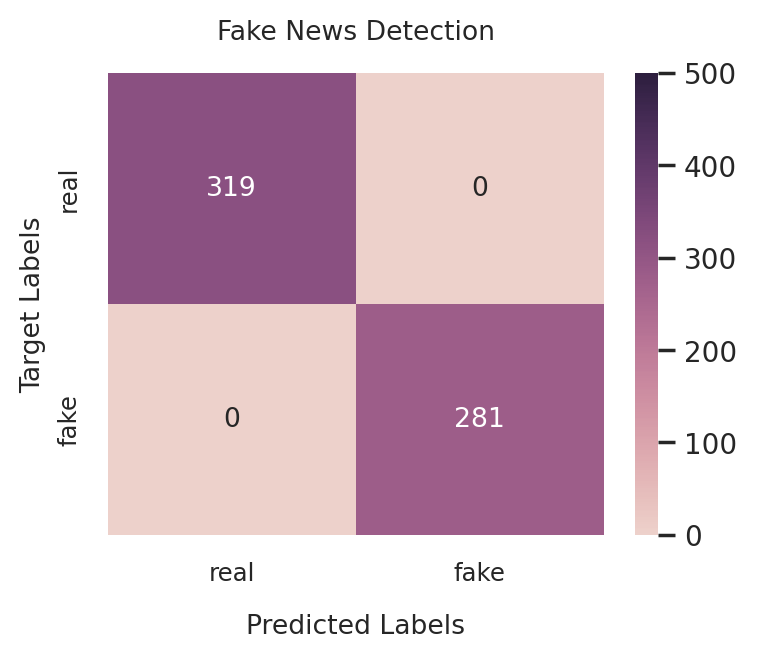

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)



# Plot confusion matrix
plt.figure(figsize=(4, 3))
# Define the custom palette
custom_palette = sns.cubehelix_palette( as_cmap=True)
# Define custom font dictionary for title and labels


# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=['real', 'fake'], yticklabels=['real', 'fake'],vmin=0,vmax=500,)

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels')
heatmap.set_ylabel('Target Labels')
heatmap.set_title('Fake News Detection', pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels())
heatmap.set_yticklabels(heatmap.get_yticklabels())

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()

# **Predicting on LLM**

In [67]:
def get_predictions_for_new_dataset(address="/content/drive/MyDrive/NLP_course_AF/LLM_generated_news/gpt_gen.csv", model=model, device=device, loss_fn=loss_fn, tokenizer=tokenizer):
    ds_fd = pd.read_csv(address)
    ds_fd['label'] = FAKE_CLASS

    token_lens_new = []

    for txt in ds_fd.text:
      #tokenizing the text
          tokens_new = tokenizer.encode(txt, max_length=512,truncation=True)
          token_lens_new.append(len(tokens_new))

    new_data_loader = create_data_loader(ds_fd, tokenizer, MAX_LEN, BATCH_SIZE)


    new_acc, new_loss = eval_model(
      model,
      new_data_loader,
      loss_fn,
      device,
      len(ds_fd)
    )

    return new_acc.item(), new_loss/len(ds_fd), get_predictions(model, new_data_loader)

In [68]:
get_predictions_for_new_dataset()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Evaluating:   0%|          | 0/5 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.52batch/s, loss=4.87]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, s

(0.4,
 0.12171719789505005,
 (["On December 22, President Trump took to Twitter to highlight two significant developments: the passing of the tax cut bill and the signing of the missile defense legislation. Trump's tweets celebrated these achievements, emphasizing their importance for the nation. The tax cut bill represented a major legislative victory for the Trump administration, fulfilling a key campaign promise to overhaul the tax code. Likewise, the signing of the missile defense bill underscored Trump's commitment to bolstering national security and modernizing the country's defense capabilities. Trump's tweets served to communicate these accomplishments directly to the American people and showcase his administration's achievements in the realms of both economic policy and defense strategy.",
   "Despite the challenge from Moore, Senator-elect Jones' certification as the winner of the U.S. Senate seat in Alabama signifies the official acknowledgment of the election results. This 

In [69]:
get_predictions_for_new_dataset(address="/content/drive/MyDrive/NLP_course_AF/LLM_generated_news/claude_gen.csv")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Evaluating:   0%|          | 0/4 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.09batch/s, loss=2.13]


(0.75,
 0.06659169611521065,
 (["President Donald Trump expressed confidence that the special counsel investigation into Russian interference in the 2016 election will be fair, but said he has no idea how long the probe will last, according to an interview with The New York Times. I have absolute right to do what I want to do with the Justice Department, Trump said, before adding, But for purposes of hopefully thinking I'm going to be treated fairly, I've stayed uninvolved. The comments come amid heightened tensions between the White House and the investigation team led by Robert Mueller. Trump's lawyers have been negotiating terms for the president to agree to an interview with Mueller's team as part of the widening probe. However, Trump declined to say when a potential interview could occur. I'll see what happens, Trump told the Times when asked about being interviewed. When they have no collusion and nobody has found any collusion at any level, it seems unlikely that you'd even have